## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
%matplotlib inline
tf.__version__

'2.3.0'

- <b>tqdm:</b> make your loops show a smart progress meter - just wrap any iterable with `tqdm(iterable)`, and you’re done!

## Helper funtion to plot graphs

In [24]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Loading and Preprocessing the Data

From this problem we don't need labels

In [3]:
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Normalization
x_train = x_train.astype(np.float32) /255.
x_test = x_test.astype(np.float32) / 255.

4423680/4422102 [==============================] - 0s 0us/step


Visualizing some data plot from our dataset. For this we are creating a (5,5) subplots.

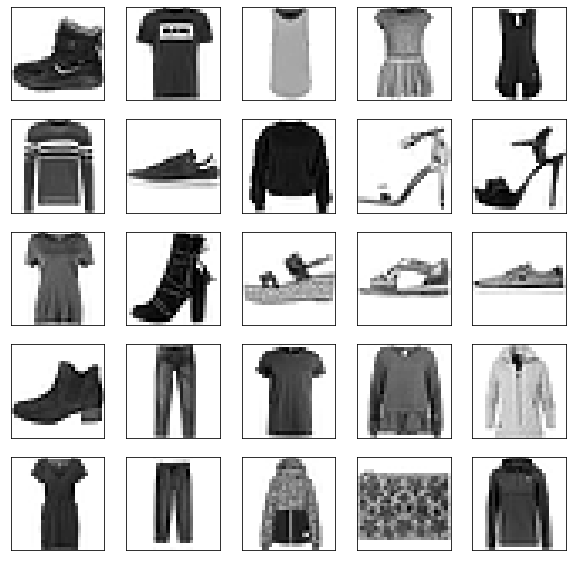

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i],cmap='binary')
plt.show()

### Creating training batches

In [5]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# This dataset fills a buffer with buffer_size elements, 
#then randomly samples elements from this buffer, replacing the selected elements with new elements.
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# This dataset is filling a buffer with a 1000 element and then radomly sampling from this 1000 elements

#Combines consecutive elements of this dataset into batches.
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(1)
# We have set drop_remainder = True so that if we get any non complete batch of 32 in the end, it'll be dropped

# for eg: 1000%32 = 8 and 1000/32 = 31.25
# This means there'll be 31 batches with filled batch_size of 32 and the last
# 32nd batch will have 8 elements only.
# So drop_remainder will drop this 32nd batch.

## Building the Generator Network for DCGAN


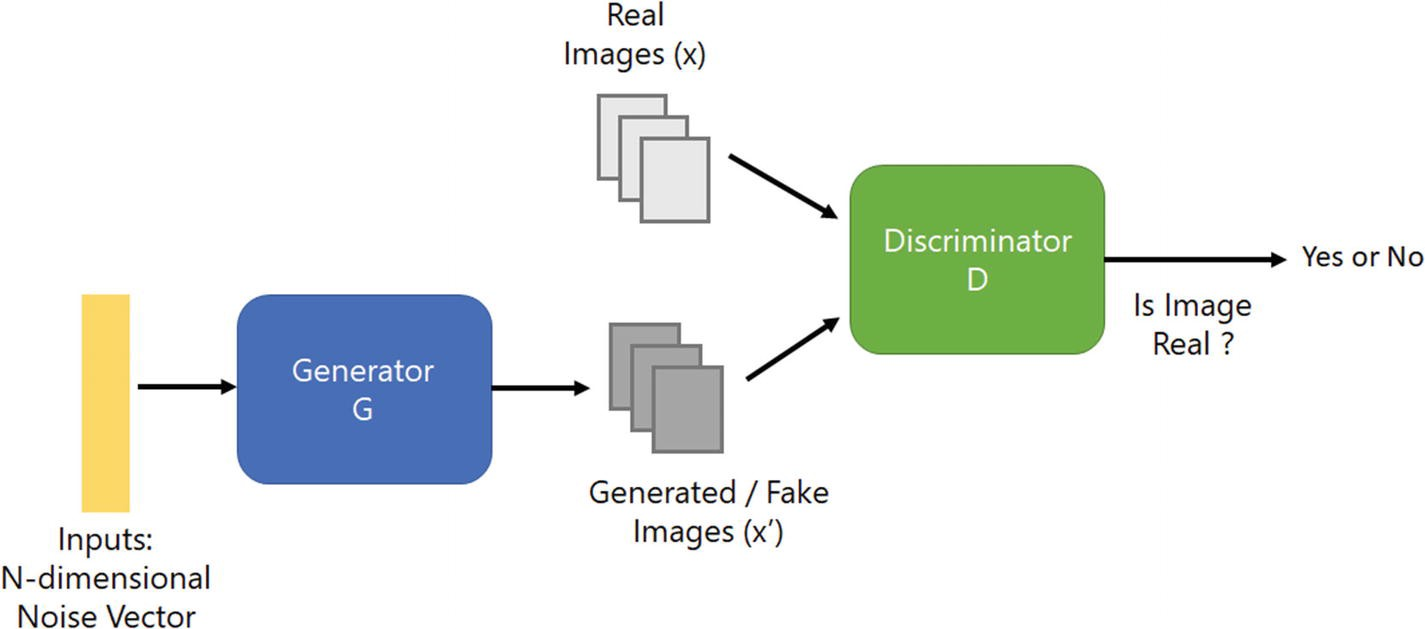

### What are GANs
Generative Adversarial Networks belong to the set of generative models. It means that they are able to produce / to generate (we’ll see how) new content.<br><br>
Generative Adversarial Networks (GANs) can be broken down into three parts:
- <b>Generative</b>: To learn a generative model, which describes how data is generated in terms of a probabilistic model.<br>
- <b>Adversarial</b>: The training of a model is done in an adversarial setting.<br>
- <b>Networks</b>: Use deep neural networks as the artificial intelligence (AI) algorithms for training purpose.<br>

### What is Generator and Discriminator?

##### Generator - An artist
##### Discriminator - An art critic
The <b>Generator</b> generates fake samples of data(be it an image, audio, etc.) and tries to fool the <b>Discriminator</b>. The <b>Discriminator</b>, on the other hand, tries to distinguish between the real and fake samples. The <b>Generator and the Discriminator are both Neural Networks and they both run in competition with each other in the training phase</b>. The steps are repeated several times and in this, the Generator and Discriminator get better and better in their respective jobs after each repetition.

In [6]:
from tensorflow.keras.layers import Dense, BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2D, Dropout, Flatten, Conv2DTranspose

selu activation funtion: Scaled Exponential Linear Unit : learn faster and better than other activation functions, even if they are combined with batch normalization.

In [7]:
NUM_FEATURES = 100
def make_generator():
    generator = tf.keras.Sequential([
        Dense(7*7*128, input_shape = [NUM_FEATURES]),
#         BatchNormalization(),
        Reshape([7,7,128]),
        BatchNormalization(),
        #upsampling
#         Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', activation='selu'),
#         BatchNormalization(),
        #upsampling
        Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', activation='selu'),
        BatchNormalization(),

        Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh')
    ])
    
    return generator

generator = make_generator()

 ### Untrained generator to create an image.
 
 Create a seed or a vector of random noise. We'll  create a normally distibuted noised image.

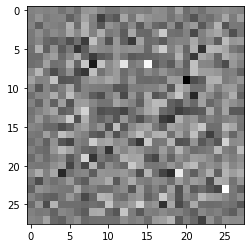

In [8]:
noise = tf.random.normal(shape=[1, NUM_FEATURES]) # 1 because we need 1 generated image
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Once we'll train out DCGAN we will see this randomly generated noise to be some object.

## Building the Discriminator Network for DCGAN
NOTE: The discriminator is a CNN-based image classifier.

In [9]:
#Fashion MNIST shape = (28,28,1)
def make_discriminator():
    discriminator = tf.keras.Sequential([
        Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(0.2),
        Dropout(0.3),

        Conv2D(128, (5,5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),

#         Conv2D(256, (5,5), strides=(1,1), padding='same'),
#         LeakyReLU(0.2),
#         Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid') #binary classificaion
    ])
    
    return discriminator

discriminator = make_discriminator()

Using untrained discriminator to classify the generated images as real or fake.

In [10]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49534404]], shape=(1, 1), dtype=float32)


## Compiling the DCGAN

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan = tf.keras.models.Sequential([generator,discriminator])
gan.compile(loss='binary_crossentropy',optimizer='rmsprop')

## Training Procedure

In [12]:
# Create a seed image for training process with shape(BATCH_SIZE, NUM_FEATUES)
# Specified earlier shape = (32,100)
seed = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])

In [13]:
# Checking if the seed image shape is as we specified or not
assert seed.shape == (32,100)

First we'll train the discriminator network for some steps and then will train the generator network. And for training a `k-steps` of discriminator network, we'll be sampling a mini-batch of noise samples from our gaussian noise prior and then also sample a mini-batch of real images from our traning dataset. And what'll do is pass the noise through the generator and get the fake images out. 

And the so we have a mini batch of both fake images and real images. And then we'll pick a gradient step on our discriminator network using this mini batch of fake and real images. And then update the discriminator parameters. And then use this and do a certain number of iterations to train the discriminator network for some steps.

In [14]:
def train_dcgan(gan, dataset, BATCH_SIZE, NUM_FEATURES, epochs = 5):
    generator, discriminator = gan.layers
    
    for epoch in tqdm(range(epochs)):
        print(f"Epochs {epoch+1}/{epochs}")
        
        for X_batch in dataset:
            # train generator to create mini batches of fake images
            # noise -> vector of random noise
            noise = tf.random.normal(shape=[BATCH_SIZE,NUM_FEATURES])
            generated_images = generator(noise)
            # concatenating generated_images with the real
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            # specify the class label
            # real images class label = 1
            # fake or generated images class label = 0
            y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)
            discriminator.trainable = True
            # training discriminator
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
            # training generator
            y2 = tf.constant([[1.]] * BATCH_SIZE) # 1 to fool the discriminator becasue that's the work of generator to fool the discriminator
            discriminator.trainable = False
            # training gan
            gan.train_on_batch(noise, y2)
            
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1, seed)
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

Generate and safe images
ref: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train DCGAN model

In [16]:
x_train_dcgan = x_train.reshape(-1,28,28,1) * 2. - 1.
assert x_train_dcgan.shape == (60000, 28, 28, 1)

# you can also explicitly provide the shape also

In [17]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True).prefetch(1)


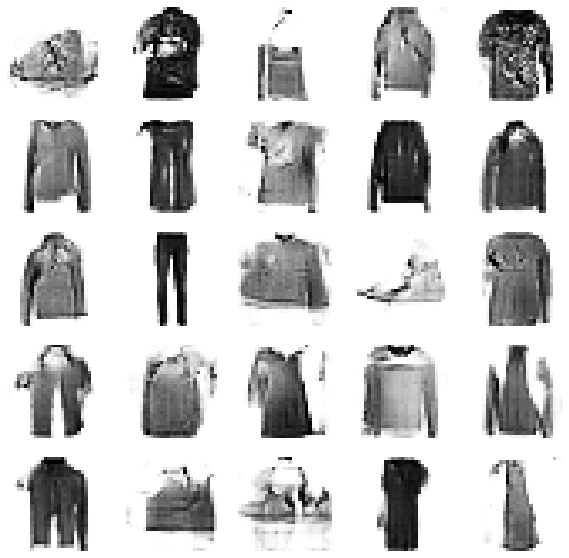

CPU times: user 5min 32s, sys: 20.8 s, total: 5min 53s
Wall time: 5min 48s


In [18]:
%%time
train_dcgan(gan,dataset, BATCH_SIZE, NUM_FEATURES, epochs = 10)


## Generating synthetic images with DCGAN

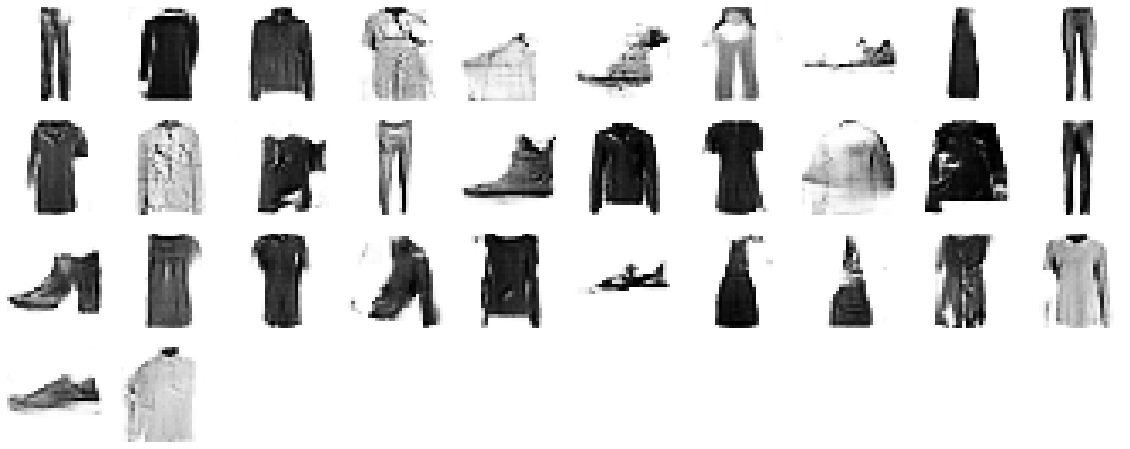

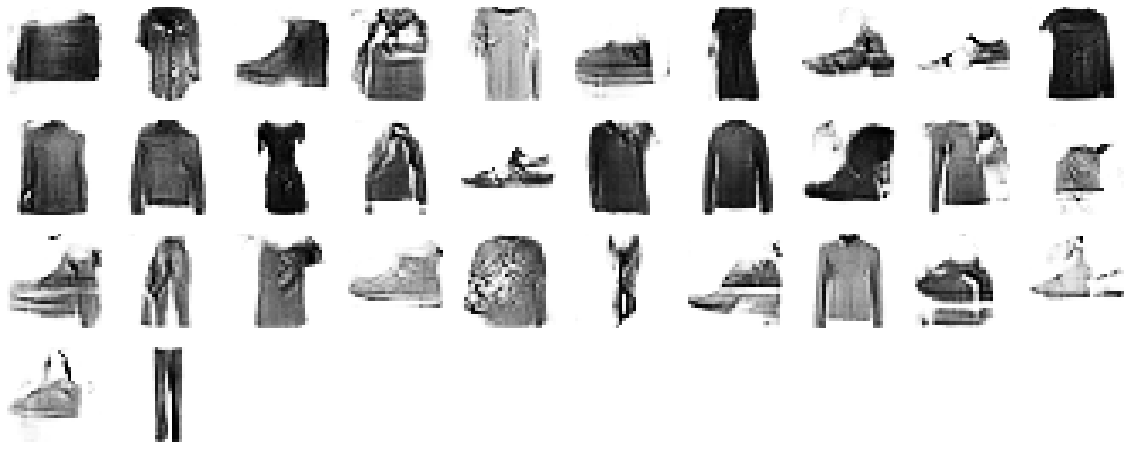

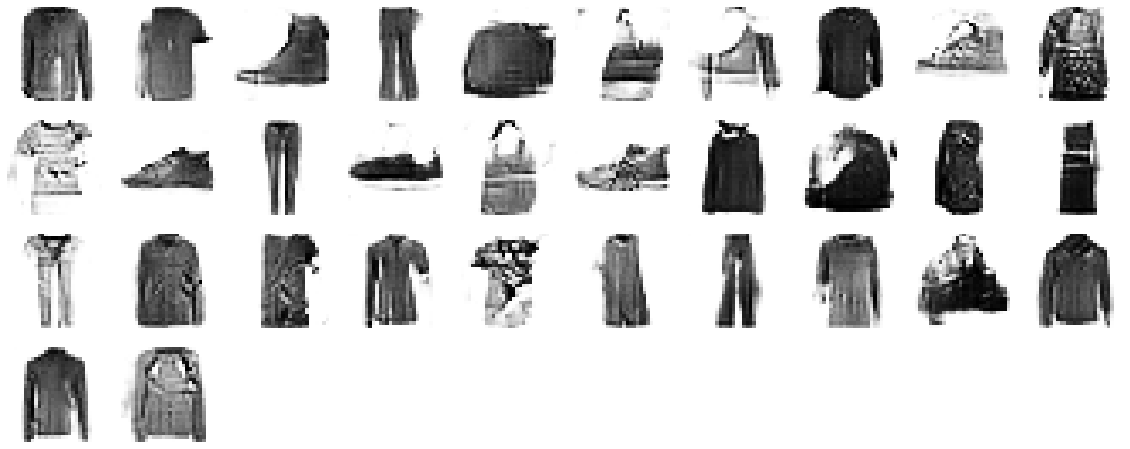

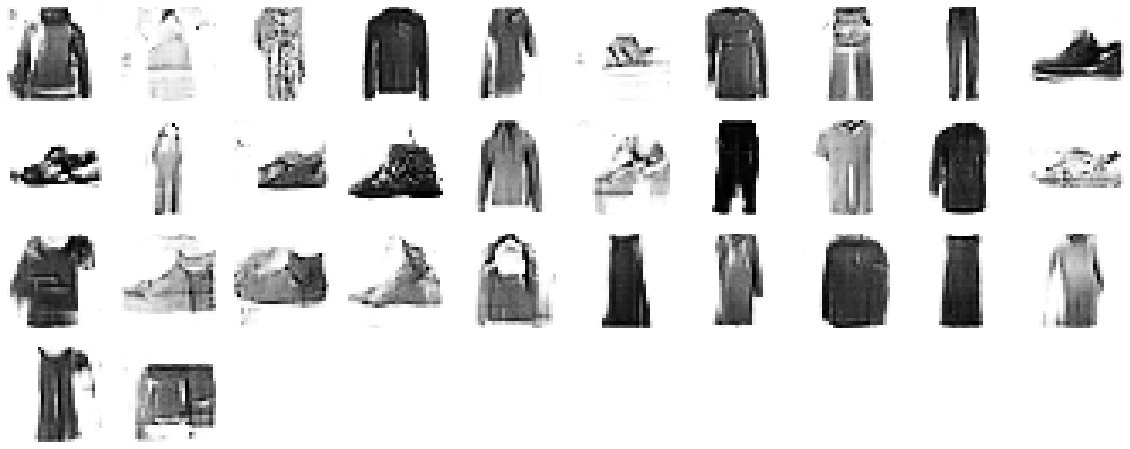

In [27]:
TIMES = 4

for _ in range(TIMES):
    noise = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
    generated_images = generator(noise)
    show(generated_images, 10)

Creating a gif of generated synthetic images
ref: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

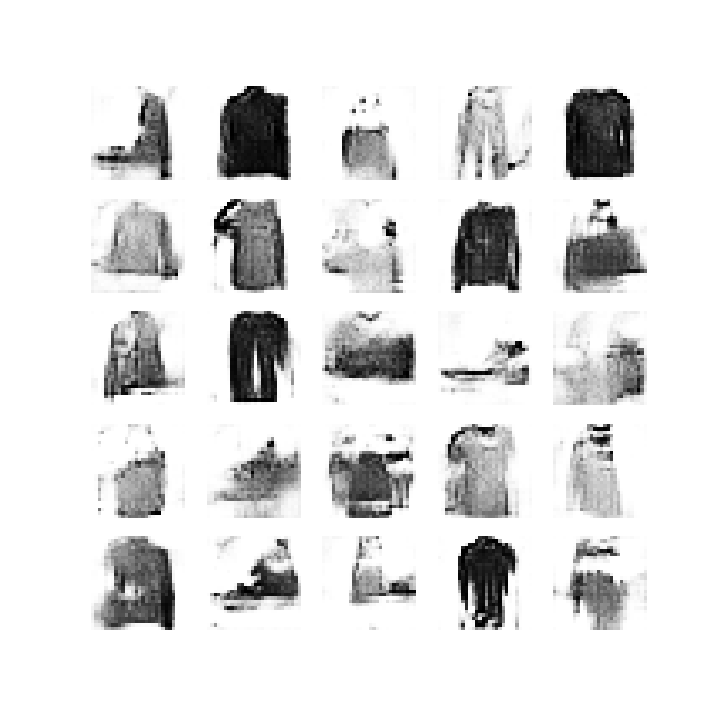

In [21]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
display.Image(filename=anim_file)

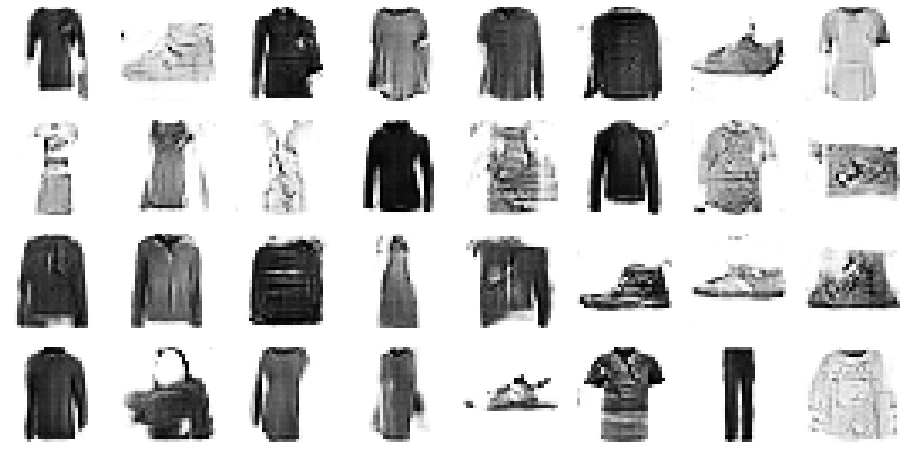

In [26]:
noise = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
generated_images = generator(noise)
show(generated_images, 8)